In [1]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import csv
import os

def run_yolo_inference(model_path, image_path, output_image_path, output_csv_path):
    # Load the YOLO model
    model = YOLO(model_path)

    # Load the image with PIL
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    width, height = img.size
    font = ImageFont.load_default()

    # Run inference on the image
    results = model(image_path)[0]

    # Prepare data for CSV
    csv_data = []

    for result in results:
        # Get the bounding box in xyxy format
        box = result.boxes.xyxy[0]
        x1, y1, x2, y2 = map(int, box)

        # Get the class ID for the detected object
        class_id = int(result.boxes.cls[0])  # Get the class ID as an integer

        # Normalize bounding box values by image width and height
        norm_x1, norm_y1 = x1 / width, y1 / height
        norm_x2, norm_y2 = x2 / width, y2 / height

        # Calculate the center of the bounding box and mark it in red
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
        norm_center_x, norm_center_y = center_x / width, center_y / height

        # Calculate normalized bounding box width and height
        bbox_width, bbox_height = x2 - x1, y2 - y1
        norm_bbox_width, norm_bbox_height = bbox_width / width, bbox_height / height

        # Get keypoints and normalize them
        keypoints = result.keypoints.xy.tolist() if result.keypoints else []
        if keypoints:
            keypoints = [(int(x), int(y)) for x, y in keypoints[0] if x != 0 and y != 0]

            # Normalize keypoints and prepare CSV data for this detection
            row = [class_id, round(norm_center_x, 2), round(norm_center_y, 2), round(norm_bbox_width, 2), round(norm_bbox_height, 2)]
            for x, y in keypoints[:8]:  # Only take the first 8 keypoints
                norm_x, norm_y = round(x / width, 2), round(y / height, 2)
                row.extend([norm_x, norm_y])

            # Trim row to exactly 21 elements (id, 4 bb info, 16 keypoint info)
            row = row[:21]
            csv_data.append(row)

In [22]:
import os
import numpy as np
import pandas as pd
from ultralytics import YOLO
from PIL import Image

# Error calculation functions
def calculate_mse(predicted, actual):
    return np.mean((predicted - actual) ** 2)

def calculate_rmse(predicted, actual):
    return np.sqrt(calculate_mse(predicted, actual))

def calculate_mae(predicted, actual):
    return np.mean(np.abs(predicted - actual))

# Paths
image_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val"
ground_truth_2d_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\2d_data"
model_path = 'C:/Users/sakar/mt-3d-environments-from-video/runs/pose/5_objects_and_edges/weights/last.pt'

# Load YOLO model
model = YOLO(model_path)

# Initialize error storage
errors = {}
predicted_points_by_image = {}

# Loop through all images in the image directory
for image_file in os.listdir(image_dir):
    if image_file.endswith((".jpg", ".png")):
        # Paths for the current image and corresponding 2D CSV
        image_path = os.path.join(image_dir, image_file)
        ground_truth_2d_path = os.path.join(ground_truth_2d_dir, image_file.replace(".jpg", ".csv").replace(".png", ".csv"))

        # Check if the corresponding 2D CSV exists
        if not os.path.exists(ground_truth_2d_path):
            print(f"Ground truth 2D data for {image_file} not found. Skipping.")
            continue

        # Perform YOLO inference
        results = model(image_path)[0]

        # Extract predicted keypoints (normalize by image dimensions)
        img = Image.open(image_path)
        width, height = img.size
        predicted_2d = []
        for result in results:
            if result.keypoints is not None:
                # Extract and normalize keypoints
                keypoints = result.keypoints.xy[0].tolist()  # First detected object
                normalized_keypoints = [(kp[0] / width, kp[1] / height) for kp in keypoints[:8]]  # Normalize first 8 keypoints
                predicted_2d.extend(normalized_keypoints)

        # Load ground truth 2D points
        try:
            ground_truth_df = pd.read_csv(ground_truth_2d_path, header=None)
            ground_truth_2d = ground_truth_df.iloc[0, 1:].values.reshape(-1, 2)  # Drop the ID column
            ground_truth_2d = [(x, y) for x, y in ground_truth_2d[:8]]  # Only take the first 8 points
        except Exception as e:
            print(f"Error loading ground truth 2D data for {image_file}: {e}")
            continue

        # Check if there are enough predicted and ground truth points
        if len(predicted_2d) < 8 or len(ground_truth_2d) < 8:
            print(f"Not enough keypoints for {image_file}. Skipping.")
            continue

        # Calculate errors
        predicted_2d = np.array(predicted_2d[:8])  # Ensure only first 8 points are used
        ground_truth_2d = np.array(ground_truth_2d)

        mse = calculate_mse(predicted_2d, ground_truth_2d)
        rmse = calculate_rmse(predicted_2d, ground_truth_2d)
        mae = calculate_mae(predicted_2d, ground_truth_2d)

        # Store errors for this image
        errors[image_file] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae
        }
        predicted_points_by_image[image_file] = predicted_2d


        print(f"Errors for {image_file}: MSE={mse}, RMSE={rmse}, MAE={mae}")

# Display all errors
errors



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val\2400.png: 384x640 2 Chairs, 1 Desk, 1 Monitor, 1 Door, 6 Edges, 91.0ms
Speed: 3.0ms preprocess, 91.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Errors for 2400.png: MSE=0.06944795977985593, RMSE=0.2635298081429422, MAE=0.22688640178969913

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val\2401.png: 384x640 2 Chairs, 1 Desk, 1 Laptop, 1 Monitor, 1 Door, 6 Edges, 33.9ms
Speed: 2.0ms preprocess, 33.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Errors for 2401.png: MSE=0.025477934855806884, RMSE=0.15961809062824578, MAE=0.1062236339413876

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val\2402.png: 384x640 1 Chair, 6 Edges, 33.9ms
Speed: 1.0ms preprocess, 33.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Errors for 2402.png: MSE=0.06126373625957466, RMSE=0.247

{'2400.png': {'MSE': 0.06944795977985593,
  'RMSE': 0.2635298081429422,
  'MAE': 0.22688640178969913},
 '2401.png': {'MSE': 0.025477934855806884,
  'RMSE': 0.15961809062824578,
  'MAE': 0.1062236339413876},
 '2402.png': {'MSE': 0.06126373625957466,
  'RMSE': 0.2475151232946679,
  'MAE': 0.13680004768396165},
 '2403.png': {'MSE': 0.06875575547720857,
  'RMSE': 0.26221318707724933,
  'MAE': 0.21725710816516453},
 '2404.png': {'MSE': 0.14766506617191572,
  'RMSE': 0.38427212515600934,
  'MAE': 0.31069607099995933},
 '2405.png': {'MSE': 0.035532959306833985,
  'RMSE': 0.18850188144109858,
  'MAE': 0.16389155244989395},
 '2406.png': {'MSE': 0.036999698633028946,
  'RMSE': 0.1923530572489789,
  'MAE': 0.15709354869039321},
 '2407.png': {'MSE': 0.036741751438246525,
  'RMSE': 0.19168137999880563,
  'MAE': 0.1507930901271608},
 '2408.png': {'MSE': 0.1682222586747622,
  'RMSE': 0.4101490688454165,
  'MAE': 0.3020456681645979},
 '2409.png': {'MSE': 0.08986842773687057,
  'RMSE': 0.29978063269142

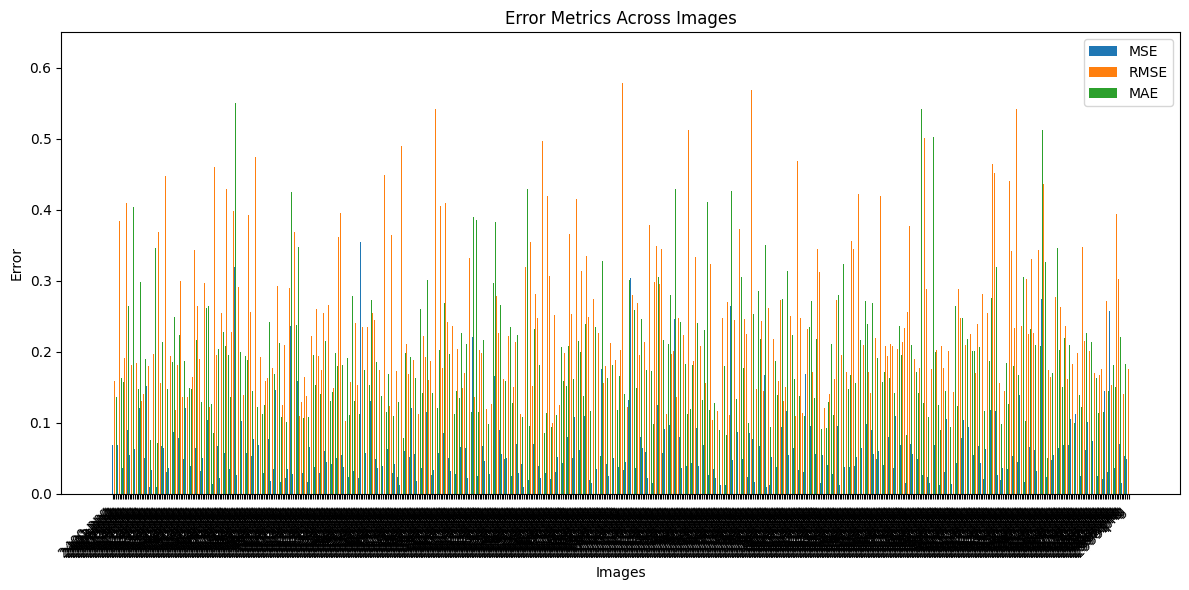

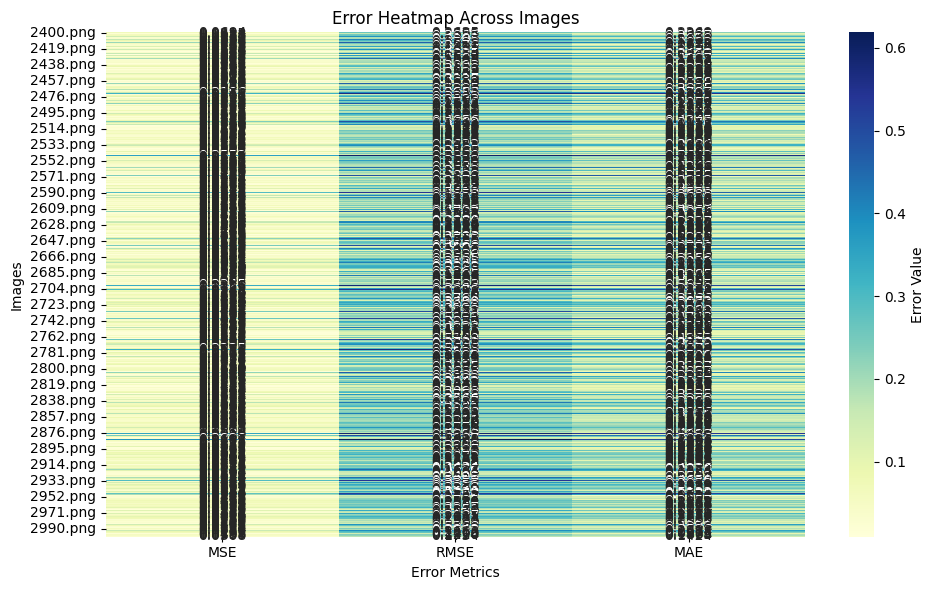

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Plot for MSE, RMSE, and MAE
image_names = list(errors.keys())
mse_values = [errors[img]["MSE"] for img in image_names]
rmse_values = [errors[img]["RMSE"] for img in image_names]
mae_values = [errors[img]["MAE"] for img in image_names]

x = np.arange(len(image_names))  # X positions for images

# Grouped Bar Chart
width = 0.25
plt.figure(figsize=(12, 6))
plt.bar(x - width, mse_values, width, label="MSE")
plt.bar(x, rmse_values, width, label="RMSE")
plt.bar(x + width, mae_values, width, label="MAE")

plt.xlabel("Images")
plt.ylabel("Error")
plt.title("Error Metrics Across Images")
plt.xticks(x, image_names, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap for Errors
heatmap_data = pd.DataFrame(errors).T  # Transpose to get images as rows
heatmap_data = heatmap_data[["MSE", "RMSE", "MAE"]]  # Ensure correct column order

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={"label": "Error Value"})
plt.title("Error Heatmap Across Images")
plt.xlabel("Error Metrics")
plt.ylabel("Images")
plt.tight_layout()
plt.show()
